In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf
import PIL 
from PIL import Image
from get_data_from_XML import XML_preprocessor
import random

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

Using TensorFlow backend.


In [2]:
class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                try:
                    # The input image is not grayscale but has a weird number of channels
                    if img.shape[2] != 3:
                        print("Problem with input image "+ key + " shape - investigate!")
                except:
                    # The input image has only 1 channel (grayscale), copy it over to 3 channels
                    img.resize((img.shape[0], img.shape[1], 1))
                    img = np.repeat(img, 3, 2)
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [3]:
# some constants
NUM_CLASSES = 41
input_shape = (300, 300, 3)

In [4]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [5]:
xml_preprocess = XML_preprocessor("/input/XMLAnnotations/")

In [64]:
data = xml_preprocess.data
keys = sorted(data.keys(), key=lambda x: random.random())
random.shuffle(keys)
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)
#num_train = int(round(0.8 * len(keys)))
#train_keys = keys[:num_train]
#train_keys = train_keys[:int(len(train_keys)*0.5)]
#num_train = len(train_keys)
#val_keys = keys[num_train:]
#val_keys = val_keys[:int(len(val_keys)*0.7)]
#num_val = len(val_keys)

In [65]:
type(keys)

list

In [67]:
train_keys[2000], val_keys[1905]

('reading_064.jpg', 'cooking_048.jpg')

In [68]:
path_prefix = '/input/JPEGImages/'
gen = Generator(data, bbox_util, 16, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), 
                saturation_var=0.6,
                brightness_var=0.6,
                contrast_var=0.6,
                hflip_prob=0.6,
                vflip_prob=0.6,
                do_crop=False)

In [125]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('/output/my_model_weights_4.h5', by_name=True)

In [92]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False

In [93]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

from keras.callbacks import ReduceLROnPlateau

reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=1, 
                             verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=1e-7)

#callbacks = [keras.callbacks.ModelCheckpoint('/output/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#                                             verbose=1,
#                                             save_weights_only=True),
#             keras.callbacks.LearningRateScheduler(schedule)]

#callbacks = [keras.callbacks.LearningRateScheduler(schedule)]
callbacks = [reducelr]

In [94]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [95]:
model.optimizer.lr.assign(0.0001968300188309513)

<tf.Tensor 'Assign_474:0' shape=() dtype=float32_ref>

In [97]:
nb_epoch = 1
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=2,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)

Epoch 1/1


/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


816s - loss: 1.4015 - val_loss: 1.6576


In [124]:
model.save_weights('/output/my_model_weights_4.h5')

In [ ]:
# Visualise 
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()
plt.imshow(img / 255.)

xmin = int(round(top_xmin[i] * img.shape[1]))
ymin = int(round(top_ymin[i] * img.shape[0]))
xmax = int(round(top_xmax[i] * img.shape[1]))
ymax = int(round(top_ymax[i] * img.shape[0]))

score = 1
label = "Car"
display_txt = '{:0.2f}, {}'.format(score, label)
coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
color = colors[1]

currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
plt.show()

In [127]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[102]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [128]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 0s


In [129]:
results[0][:, 1]

array([ 0.9684059 ,  0.1218174 ,  0.0209284 ,  0.01630636,  0.01615136])

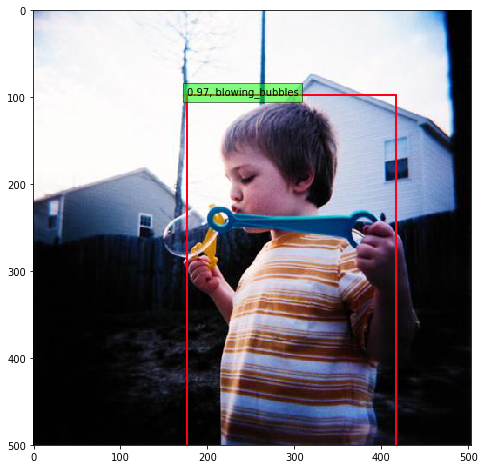

In [130]:
voc_classes = ['applauding', 'blowing_bubbles', 'brushing_teeth', 'cleaning_the_floor', 'climbing', 'cooking', 'cutting_trees',
              'cutting_vegetables', 'drinking', 'feeding_a_horse', 'fishing', 'fixing_a_bike', 'fixing_a_car', 'gardening', 
              'holding_an_umbrella', 'jumping', 'looking_through_a_microscope', 'looking_through_a_telescope', 'playing_guitar',
              'playing_violin', 'pouring_liquid', 'pushing_a_cart','reading', 'phoning', 'riding_a_bike', 'riding_a_horse', 
              'rowing_a_boat', 'running', 'shooting_an_arrow', 'smoking', 'taking_photos', 'texting_message', 'throwing_frisby',
              'using_a_computer', 'walking_the_dog', 'washing_dishes', 'watching_TV', 'waving_hands', 'writing_on_a_board', 
              'writing_on_a_book']

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.99266422  0.03098735  0.0237799   0.01766145]


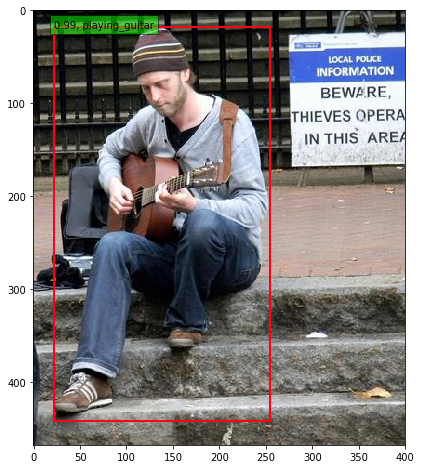

In [111]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[972]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.65]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.7967971   0.47502553  0.13695763  0.03453726  0.02646636  0.02584506
  0.0173387   0.01429112  0.01320694  0.01215858  0.01058352]


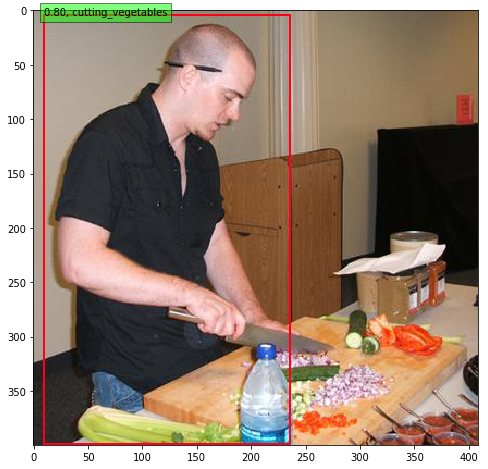

In [131]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[344]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.65]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.96231359  0.23679353  0.11530152  0.02875741  0.02414199  0.0184198
  0.01590861  0.01489752  0.01444958  0.01404794  0.01346393  0.01292044
  0.01289723  0.01149636  0.01113954  0.01088225]


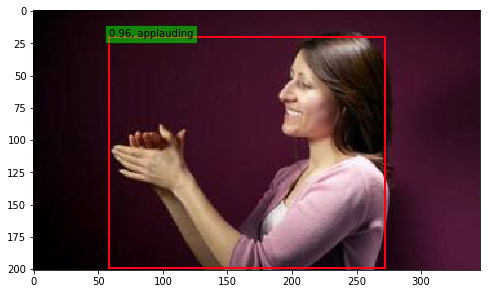

In [132]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[25]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.65]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.94425273  0.5407272   0.28289098  0.07504951  0.05590832  0.05178389
  0.05163616  0.04635794  0.04028166  0.03281155  0.03070587  0.02984666
  0.02942056  0.02932224  0.02767694  0.02530134  0.0235534   0.02330326
  0.0219652   0.01999013  0.01879516  0.01634724  0.01131421  0.01100933
  0.01100568  0.01082213]


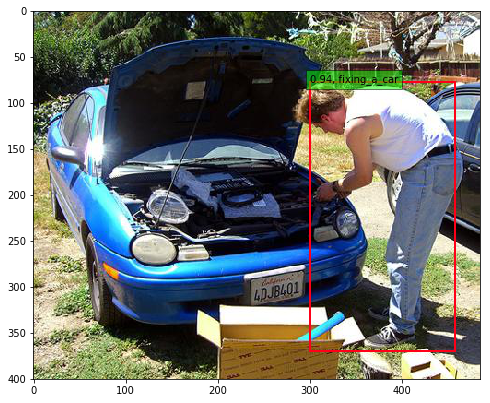

In [87]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[612]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.65]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.94158733  0.34734133  0.22905244  0.13024074  0.07611006  0.07037394
  0.05087237  0.05063431  0.03032337  0.02727058  0.02646954  0.02416594
  0.02109176  0.01998258  0.01964143  0.01894176  0.01843479  0.01784043
  0.01744314  0.01738271  0.01730805  0.01666143  0.01629089  0.01533804
  0.01443286  0.01412736  0.01398264  0.01373706  0.01244042  0.01177222
  0.01123432  0.0111985   0.0110224   0.01056907  0.01053673  0.0103507 ]


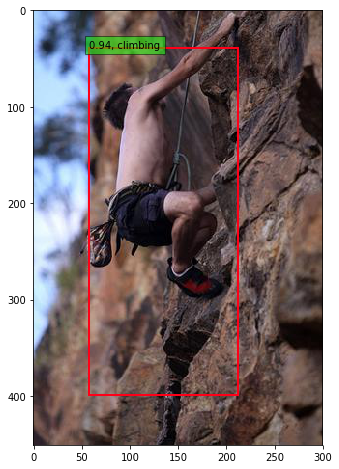

In [88]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[188]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.65]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.95635504  0.13472284  0.06249141  0.06172358  0.05564512  0.05355675
  0.04906792  0.04692463  0.04489918  0.03905923  0.0286063   0.02765726
  0.02652174  0.02571569  0.0252203   0.02454333  0.02436307  0.02346181
  0.02254661  0.02160342  0.02118025  0.02099782  0.0207758   0.02017486
  0.01896934  0.01746896  0.01737815  0.01720736  0.01657555  0.01593911
  0.01593429  0.01465064  0.014506    0.01438621  0.01436639  0.01419336
  0.01399606  0.01388174  0.01375475  0.01350387  0.01329184  0.01241853
  0.01240898  0.01205337  0.01200657  0.01175142  0.01175018  0.01134899
  0.01120814  0.01096762  0.01074558  0.01068296  0.01065655  0.01054845
  0.01050214  0.01025794  0.01002684]


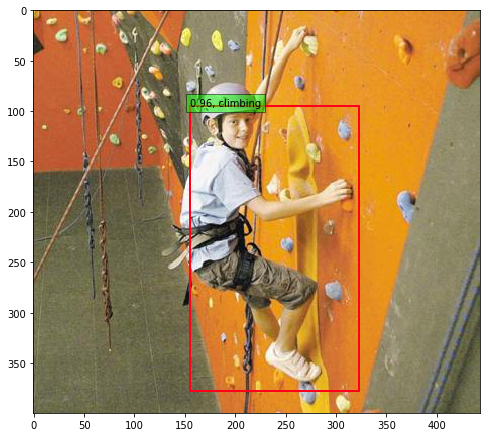

In [112]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[237]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.65]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.91780478  0.18338633  0.15459262  0.12271618  0.11851918  0.09316972
  0.08605554  0.0827316   0.06272867  0.05634633  0.0545077   0.05384966
  0.05279559  0.04485083  0.04040216  0.03986306  0.03758468  0.03510304
  0.03154619  0.03092175  0.03057478  0.02993953  0.02907532  0.02876384
  0.02814601  0.0276533   0.0275217   0.0268624   0.02610707  0.02376812
  0.02296552  0.02251418  0.02193497  0.02193217  0.02173669  0.02116066
  0.0210628   0.02046244  0.01912758  0.01906819  0.01855472  0.0169924
  0.01692677  0.01667111  0.01642701  0.01583004  0.01567846  0.01531451
  0.01486215  0.01463326  0.01430972  0.01410427  0.01404754  0.01347828
  0.01293034  0.01255111  0.01218256  0.01134581  0.01130051  0.01078181
  0.01042266  0.01040755  0.01033201]


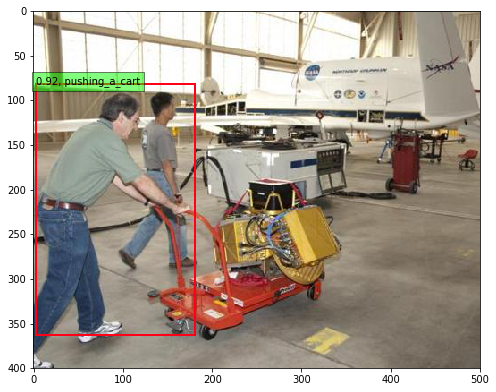

In [119]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[1108]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.60]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.68402517  0.25086993  0.15006739  0.13614312  0.12231003  0.05997069
  0.05728264  0.04357874  0.03610346  0.03188556  0.02792503  0.02294948
  0.0218565   0.02159744  0.02104374  0.01900259  0.01768909  0.01586081
  0.01505872  0.01479496  0.01385805  0.01213817  0.01118613]


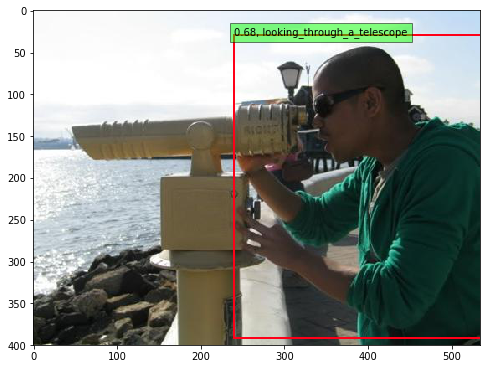

In [120]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[872]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.60]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.53080451  0.31412292  0.25674039  0.1971094   0.16666077  0.12767859
  0.10022588  0.08797841  0.07451005  0.06075191  0.05539551  0.04804928
  0.04359305  0.04295335  0.04072233  0.0399895   0.03476114  0.03448381
  0.03339351  0.03261252  0.03113247  0.028469    0.02813748  0.02660816
  0.02307178  0.02220424  0.02181058  0.02143239  0.02104447  0.02090273
  0.02011746  0.01969393  0.01953547  0.01938991  0.01849936  0.01830363
  0.01807403  0.01775986  0.01646574  0.01628743  0.01538547  0.0153526
  0.01504175  0.01380723  0.01330827  0.01324925  0.01309348  0.01300903
  0.01256146  0.01244508  0.01226849  0.01186812  0.01064649  0.01022544
  0.01021763]


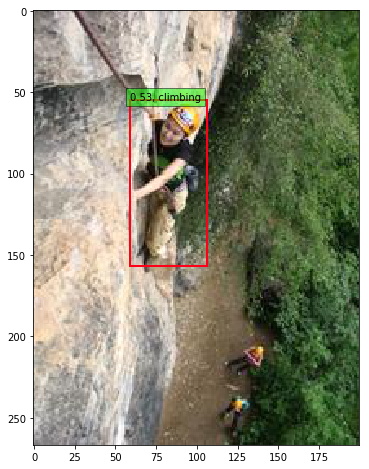

In [122]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[223]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()

1/1 [==============================] - 0s
[ 0.73568624  0.18795821  0.18618414  0.12477927  0.10479737  0.09001682
  0.07597681  0.05716791  0.04013579  0.03766043  0.03753095  0.03422228
  0.02880651  0.02622608  0.02503134  0.02471921  0.02107517  0.02065253
  0.02060445  0.02045604  0.01946126  0.01927293  0.01857046  0.01855027
  0.0169932   0.01697637  0.01689785  0.01629719  0.0159558   0.01586805
  0.01570443  0.01476837  0.01437779  0.01430586  0.01422505  0.01407069
  0.01366281  0.01355472  0.01342587  0.01336903  0.01335331  0.01323314
  0.01316071  0.01313383  0.01297357  0.0122026   0.01185276  0.01167369
  0.01126475  0.0111117   0.01105822  0.01074186  0.01074024  0.01058778
  0.01058241  0.01052795  0.01049761  0.01003523]


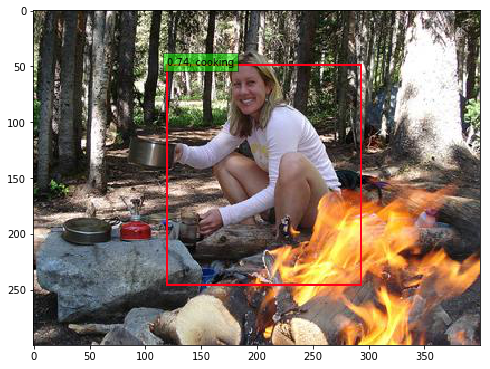

In [123]:
inputs = []
images = []
img_path = path_prefix + sorted(val_keys)[255]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

print(results[0][:, 1])

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.60]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[3]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':colors[1], 'alpha':0.5})
    
    plt.show()